# Working with NIfTI images

[NIfTI](https://nifti.nimh.nih.gov/) stands for *Neuroimaging Informatics Technology Initiative*, which is jointly sponsored by the US  National Institute of Mental Health and the National Institute of Neurological Disorders and Stroke. NIfTI defines a file format for neuroimaging data that is meant to meet the needs of the fMRI research community. In particular, NIfTI was developed to support inter-operability of tools and software through a common file format. Prior to NIfTI there were a few major fMRI analysis software packages, and each used a different file format. NIfTI was designed to serve as a common file format for all of these (and future) neuroimaging software packages. 

NIfTI was derived from an existing medical image format, called ANALYZE. ANALYZE was originally developed by the Mayo Clinic in the US, and was adopted by several neuroimaging analysis software packages in the 1990s. The ANALYZE header (where meta-data are stored) had extra fields that were not used, and NIfTI format basically expands on ANALYZE by using some of those empty fields to store information relevant to neuroimaging data. In particular the header stores information about the position and orientation of the images. This was a huge issue prior to NIfTI. In particular, there were different standards for how to store the order of the image data. For example, some software packages stored the data in an array that started from the most right, posterior, and inferior voxel, with the three spatial dimensions ordered right-to-left, posterior-to-anterior, and then inferior-to-superior. This is referred to as RPI orientation. Other packages that also used ANALYZE data stored the voxels in RAI format (with the second dimension going anterior-to-posterior) or LPI format (reversing left and right). This caused a lot of problems for researchers, especially if they wanted to try different analysis software, or use a pipeline that involved tools from different software packages. In some cases, this was just annoying (e.g., having to reverse the anterior-posterior dimension of an image). In other cases, it was confounding and potentially created erroneous results. This was especially true of the right-left (*x*) dimension. While it is immediately obvious when viewing an image which the front and back, and top and bottom, of the brain are, the left and right hemispheres are typically indistinguishable from eahc other, so a left-right swap could easily go undetected, potentially leading researchers to make completely incorrect conclusions about which side of the brain activation occurred on! The NIfTI format was designed to help prevent this by more explicitly storing orientation information in the header.

Another improvement with the NIfTI format was to allow a single file. ANALYZE format requires two files, a header (with a `.hdr` extension) and the image data itself (`.img`). These files had to have the same name prior to the extension (e.g., `brain_image.hdr` and `brain_image.img`), and doubled the number of files in a directory of images, which created more clutter. NIfTI defines a single image file ending in a `.nii` extension. As well, NIfTI images can be compressed using a standard, open-source algorithm known as Gzip, which can significantly reduce file sizes and thus the amount of storage required for imaging data. Since neuroimaging data files tend to be large, this compression was an important feature. 

Although other file formats are still used by some software, NIfTI has become the most widely used standard for fMRI and other MRI research data file storage. Here we will learn how to convert a DICOM file to NIfTI format, which is typically the first step in an MRI research analysis pipeline, since most MRI scanners produce DICOM files, but the software researchers use to process their data reads NIFTI and not DICOM format.

## Import packages

Here we load in Python packages designed to work with NIfTI data:
- `pydicom` reads DICOM files
- `NiBabel` reads and converts between NIfTI and several other common neuroimaging file formats, including ANALYZE, and can convert DICOM series to NIfTI
- `NiLearn` is primarily designed to provide statistical analysis and machine learning tools for neuroimaging data. However, it also provides a number of utilities for reading and writing NIfTI images, and working with and visualizing data

As well we'll load SciPy's ndimage package, and Matplotlib

In [ ]:
import pydicom
import nibabel as nib
from nibabel.nicom import dicomreaders
import nilearn as nil
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os
import glob
import numpy as np


/var/folders/nq/chbqhzjx5hb6hfjx708rh2_40000gn/T/ipykernel_95468/4248759852.py:3: UserWarning: The DICOM readers are highly experimental, unstable, and only work for Siemens time-series at the moment
Please use with caution.  We would be grateful for your help in improving them
  from nibabel.nicom import dicomreaders


We will use `NiBabel`'s DICOM reader to convert the structural MRI images we worked with in the previous lesson from DICOM to NIfTI. NiBabel can read a directory of DICOM files and convert them to NIfTI format. We'll use `glob` to find all DICOM files in the directory, then use NiBabel to read them and save as a compressed NIfTI file.

Here we will first list the contents of the `data` folder, then perform the conversion, and then list the contents again to see the new NIfTI file:

In [2]:
os.listdir('data')

['.DS_Store',
 '4_sag_3d_t1_spgr.nii.gz',
 'anatomical_aug13_001.hdr',
 'Anat001.20040930.145131.5.T1_GRE_3D_AXIAL.0099.dcm',
 'anatomical_aug13_001.img',
 'DICOM']

In [ ]:
# Get list of DICOM files
dicom_files = sorted(glob.glob('data/DICOM/*.dcm'))
print(f"Found {len(dicom_files)} DICOM files")

# Read DICOM files and stack into a 3D array
slices = []
for file_path in dicom_files:
    ds = pydicom.dcmread(file_path)
    slices.append(ds.pixel_array)

# Stack slices into 3D array
volume_data = np.stack(slices, axis=0)

# Read metadata from first DICOM file
first_ds = pydicom.dcmread(dicom_files[0])

# Create NIfTI image with proper affine matrix
# This creates a simple affine based on DICOM spacing
affine = np.eye(4)
if hasattr(first_ds, 'PixelSpacing'):
    affine[0, 0] = first_ds.PixelSpacing[0]
    affine[1, 1] = first_ds.PixelSpacing[1]
if hasattr(first_ds, 'SliceThickness'):
    affine[2, 2] = first_ds.SliceThickness

nifti_img = nib.Nifti1Image(volume_data, affine)

# Save as compressed NIfTI file
nib.save(nifti_img, 'data/brain_scan.nii.gz')

# List directory contents
os.listdir('data')

Found 184 DICOM files


['.DS_Store',
 '4_sag_3d_t1_spgr.nii.gz',
 'anatomical_aug13_001.hdr',
 'Anat001.20040930.145131.5.T1_GRE_3D_AXIAL.0099.dcm',
 'brain_scan.nii.gz',
 'anatomical_aug13_001.img',
 'DICOM']

So the new converted file is `brain_scan.nii.gz`

## Load NIfTI file

We use `NiBabel` to read in the NIfTI file we just created:

In [4]:
brain_vol = nib.load('data/brain_scan.nii.gz')

# What is the type of this object?
type(brain_vol)

nibabel.nifti1.Nifti1Image

## View metadata

We can view the image's header by printing it (note that due to how the NiBabel `Nifti1Image` object is coded, we need to `print()` the header rather than just asking for it as a property):

In [5]:
print(brain_vol.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'')
dim_info        : 0
dim             : [  3 184 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.bytes_(b'')
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
sr

## Access data in the NIfTI object

NiBabel's handling of the NIfTI format data is not quite as elegant as what we saw in the previous lesson. Rather than being able to access the data directly by referencing the name of the object (in this case, `brain_vol`), we need to use the method `get_fdata()` to do this (the "f" in this method name stands for "floating point", as this is the type of data it returns). We will assign the result of this to a new variable so that it's easy to work with. 

In [6]:
brain_vol_data = brain_vol.get_fdata()
type(brain_vol_data)

numpy.ndarray

We see that the data is a familiar NumPy array, and below we see the dimensions are identical to what we saw for this image in the previous lesson:

In [7]:
brain_vol_data.shape

(184, 256, 256)

## Visualize a slice

We can use `.plt.imshow()` as in the previous lesson:

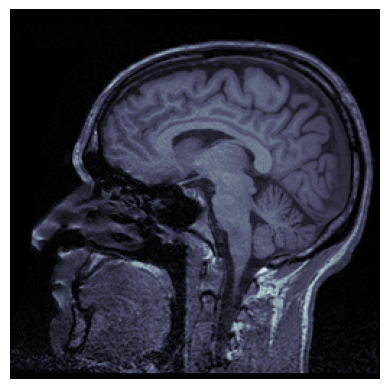

In [8]:
plt.imshow(brain_vol_data[96], cmap='bone')
plt.axis('off')
plt.show()

Note that our image is rotated, so use can use `ndi.rotate` to fix this:

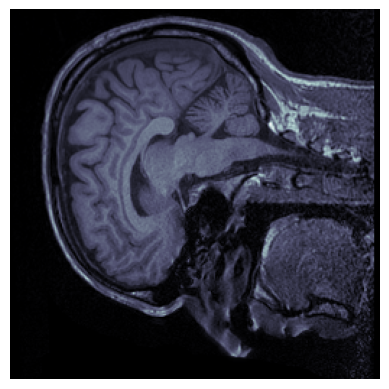

In [9]:
plt.imshow(ndi.rotate(brain_vol_data[96], 90), cmap='bone')
plt.axis('off')
plt.show()

## Plot a series of slices

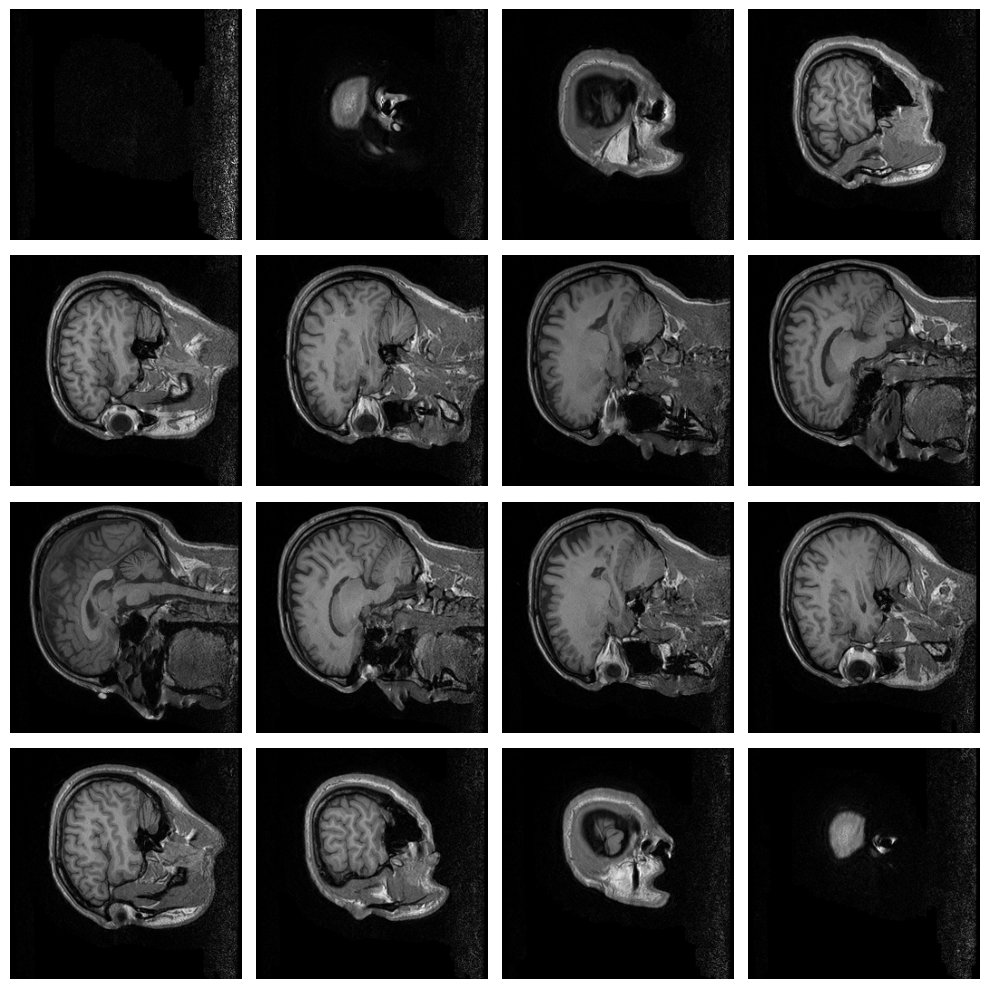

In [10]:
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = brain_vol_data.shape[0]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(brain_vol_data[img, :, :], 90), cmap='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

## Plot with NiLearn

While SciPy's ndimage module was designed for working with a wide variety of image types, NiLearn was designed to work with neuroimaging data specifically. As such, it's tools are a bit easier to use and more purpose-built for tasks that neuroimaging data scientists might want to perform. For example, we can plot the NiBabel NIfTI image object directly without first having to extract the data, using the `plot_img()` function from NiLearn's `plotting` module:

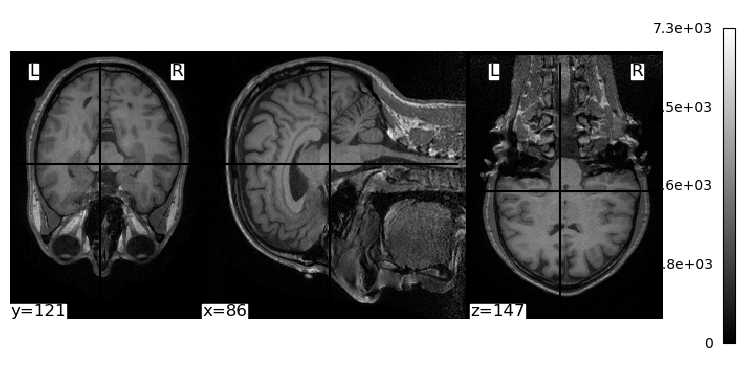

In [11]:
from nilearn import plotting

plotting.plot_img(brain_vol)
plt.show()

One nice thing that we see is that since NiLearn is neuroimaging-aware, it explicitly adds labels to our plot showing us clearly which the left and right hemispheres are.

NiLearn's plotting library uses Matplotlib, so we can use familiar tricks to do things like adjust the image size and colormap:

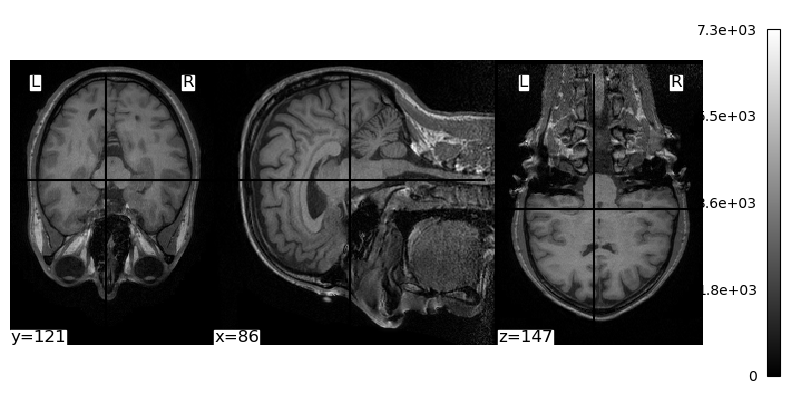

In [12]:
from nilearn import plotting

fig, ax = plt.subplots(figsize=[10, 5])
plotting.plot_img(brain_vol, cmap='gray', axes=ax)
plt.show()

The `plot_img()` function also provides a variety of ways to display the brain, with much less code than we had to use when working with raw NumPy arrays and Matplotlib functions:

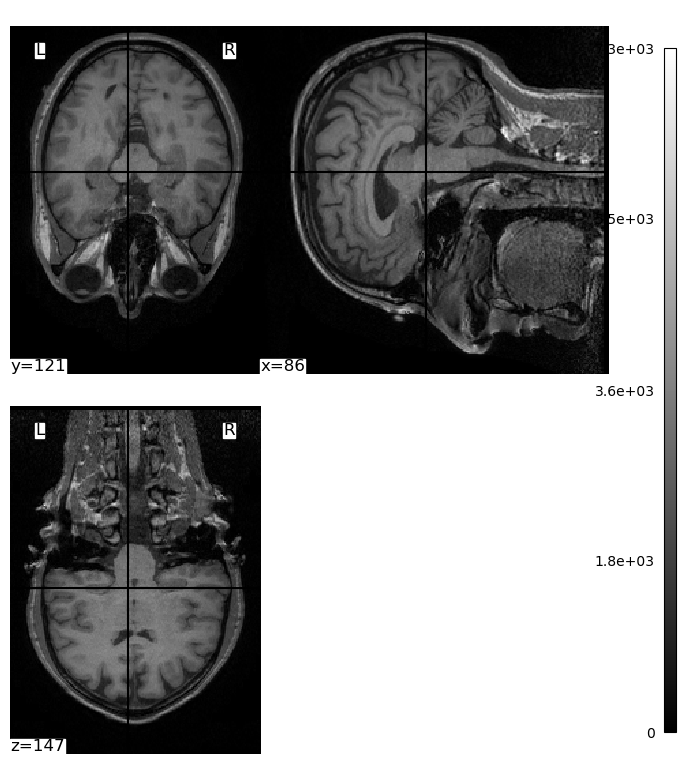

In [13]:
plotting.plot_img(brain_vol, display_mode='tiled', cmap='gray')
plt.show()

We can use the `cut_coords` kwarg to specify there to centre the crosshairs and "cuts" through the image that we visualize. In this image, the coordinates are relative to the *isocenter of the MRI scanner — the centre of the magnetic field inside the scanner. The position of a person's head relative to this isocenter will vary from individual to individual, and scan to scan, due to variations in head size and the optimizations used by the MRI technician and scanner. But we can use the coordinates printed in the above image (which defaulted to the centre of the image volume) and some trial-and-error to get a different view through the brain:

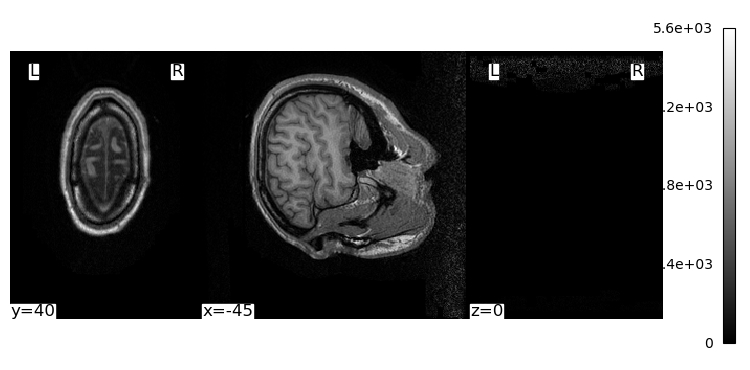

In [14]:
plotting.plot_img(brain_vol, cmap='gray', cut_coords=(-45, 40, 0))
plt.show()

`plot_img()` also has a few other ways to see multiple slices at once:

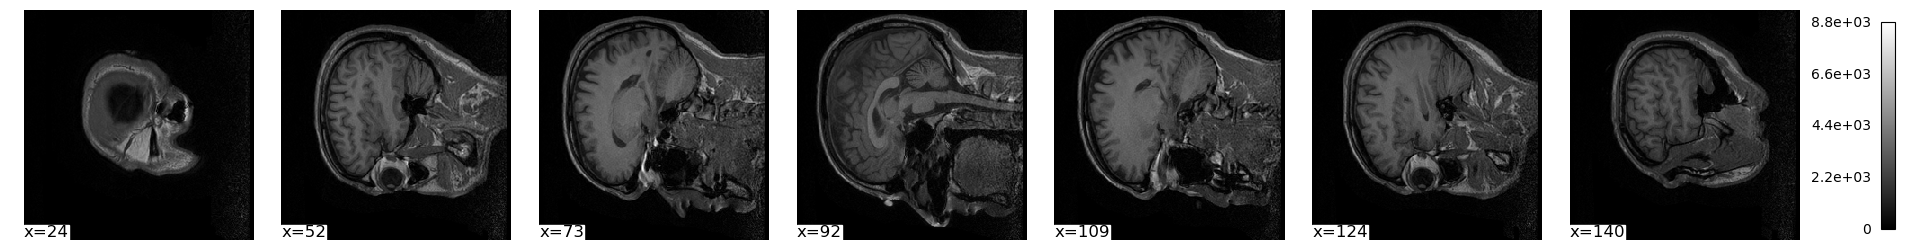

In [15]:
plotting.plot_img(brain_vol, display_mode='x', cmap='gray')
plt.show()

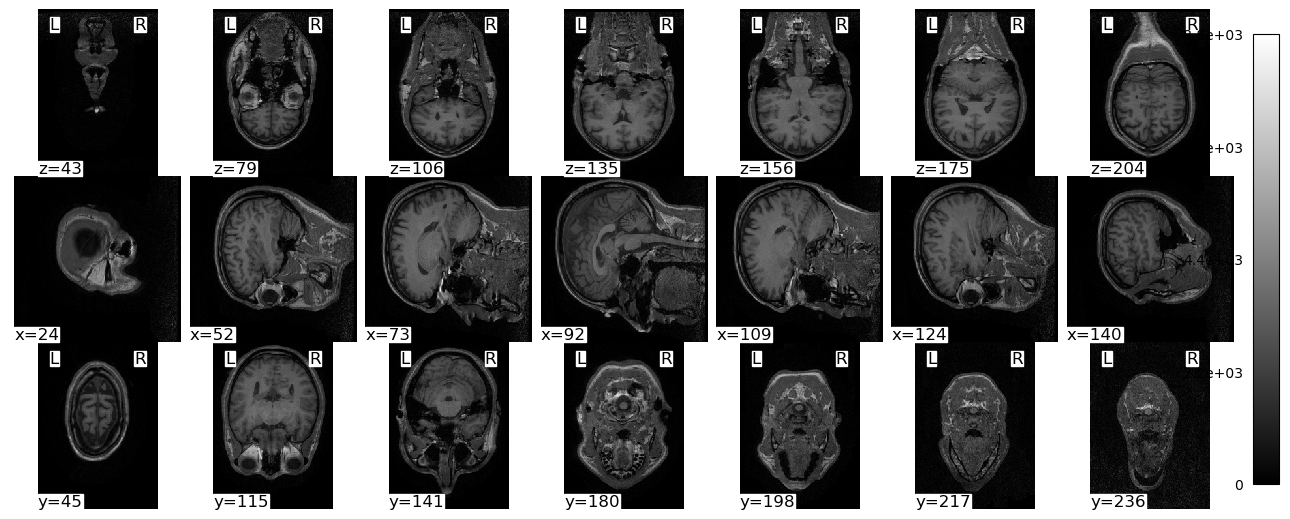

In [16]:
plotting.plot_img(brain_vol, display_mode='mosaic', cmap='gray')
plt.show()

## Smoothing

NiLearn has its own function for applying Gaussian spatial smoothing to images as well. The only real difference from scipy.ndimage's `gaussian_filter()` function is that instead of specifying the smoothing kernel in standard deviations, we specify it in units of **full width half-maximum (FWHM)**. This is the standard way that most neuroimaging analysis packages specify smoothing kernel size, so it is preferable to SciPy's approach. As the term implies, FWHM is the width of the smoothing kernel, in millimetres, at the point in the kernel where it is half of its maximum height. Thus a larger FWHM value applies more smoothing.

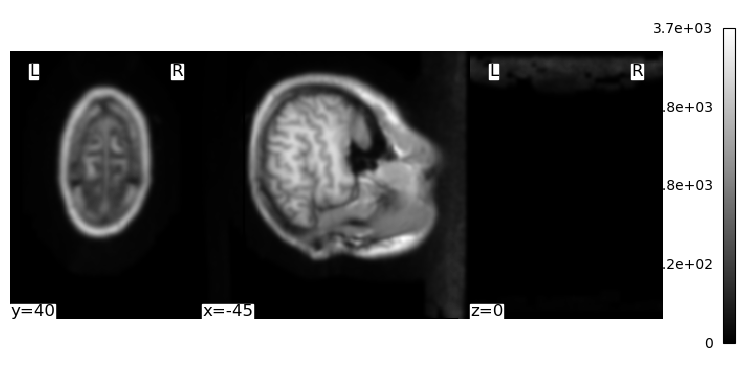

In [17]:
from nilearn import image

fwhm = 4

brain_vol_smth = image.smooth_img(brain_vol, fwhm)
plotting.plot_img(brain_vol_smth, cmap='gray', cut_coords=(-45, 40, 0))
plt.show()